This notebook shows how to **define** **3D** **vector fields** based by revolving **2D** **vector fields**.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go

from spomso.cores.helper_functions import generate_grid, smarter_reshape, vector_smarter_reshape

from spomso.cores.geom_3d import X
from spomso.cores.geom_vector import VectorFieldFromSDF

# PARAMETERS

In [2]:
# size of the volume
co_size = 100, 100, 100
# resolution of the volume
co_resolution = 50, 50, 50

# show 2D cross-section along the z-axis
show_midplane = True
# index of the cross-section along the z-axis
depth_index = 0
# 1/decimate of total vectors are shown in the cross-section
decimate = 4

# revolve_axis: "X", "Y", "Z"
revolve_axis = "X"

# show a 3D plot
show_3d = False
show_field = True
show_field_3d = False

There are 3 sub-examples in this notebook showing how to create a 3D vector field by revolving a 2D vector field around one of the principal axes (`revolve_axis`):

* X
* Y
* Z

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a **numpy.ndarray** with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SCALAR FIELDS

Define the **SDF**:

In [4]:
vfs = X(0)
vfs.rotate(np.pi/4, (0, 0, 1))

Evaluate the **SDF** to create a signed distance field 3D map:

In [5]:
vfs_pattern = vfs.create(coor)

## SHOW SCALAR FIELDS

(51, 51, 51)


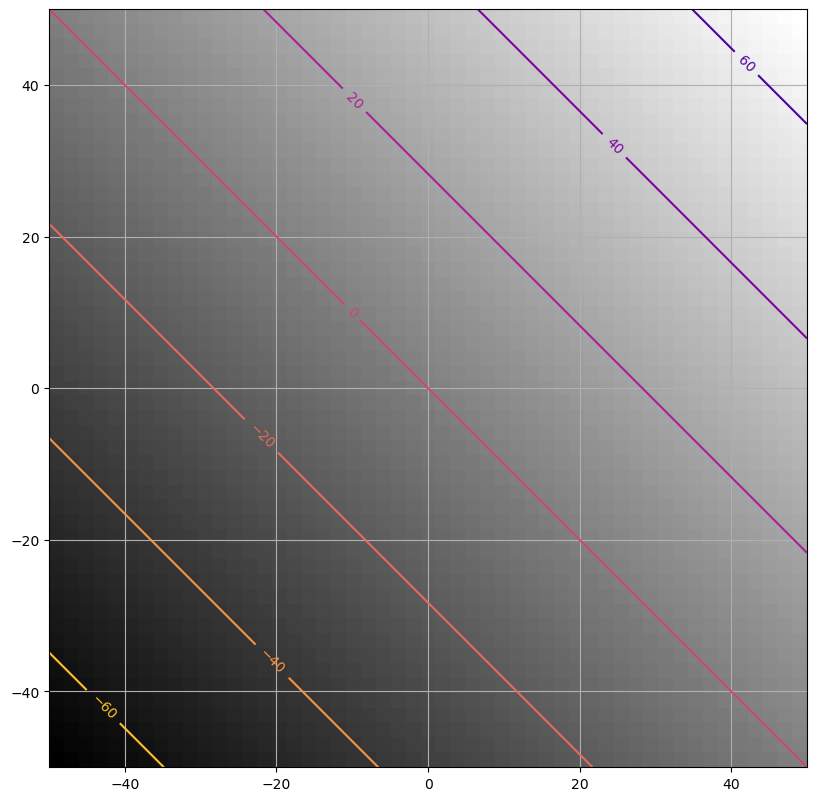

In [6]:
if show_midplane and show_field:
    field = smarter_reshape(vfs_pattern, co_resolution)
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    print(field.shape)
    ax.imshow(field[:, :, depth_index].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    z_mask = coor[2] == -co_size[2]/2
    cs = ax.contour(coor[0, z_mask].reshape(co_res_new[0], co_res_new[1]),
                    coor[1, z_mask].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :, depth_index],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()

    fig.tight_layout()
    plt.show()

In [7]:
if show_field_3d and show_field:
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=vfs_pattern,
        isomin=-0,
        isomax=20,
        opacity=0.1,
        surface_count=5,
    ))

    fig.update_layout(
        scene=dict(
            aspectmode="manual",
            aspectratio=dict(x=1, y=co_size[1]/co_size[0], z=co_size[2]/co_size[0])
        )
    )

    fig.show()

# CREATE VECTOR FIELDS

To create the **vector field** use the function `VectorFieldFromSDF` to which we pass the **resolution** (`co_resolution`) of the grid on which the **vector field** will be evaluated:

In [8]:
final = VectorFieldFromSDF(co_resolution)

The **vector field** can be modifed by **revolving** the vectors around an **axis**.

**Revolve** the **vector field** around the **x-axis**:

In [9]:
if revolve_axis == "X":
    final.revolution_x(coor)

**Revolve** the **vector field** around the **y-axis**:

In [10]:
if revolve_axis == "Y":
    final.revolution_y(coor)

**Revolve** the **vector field** around the **z-axis**:

In [11]:
if revolve_axis == "Z":
    final.revolution_z(coor)

## EVALUATE

Evaluate the **vector field** functions to create a map of the **vector field**. This is done by calling the **create** method and passing in the evaluated **SDF** (**UDF**):

In [12]:
final_field = final.create(vfs_pattern)

# EXTRACT

Extract the **x**, **y**, and **z** components of the **vector field**:

In [13]:
x = final.x(vfs_pattern)
y = final.y(vfs_pattern)
z = final.z(vfs_pattern)

Extract the **phi** (azimuthal) and **theta** (polar) angles, and the vector **lengths**:

In [14]:
phi = final.phi(vfs_pattern)
theta = final.theta(vfs_pattern)
length = final.length(vfs_pattern)

Convert the field maps into grids:

In [15]:
field = vector_smarter_reshape(final_field, co_resolution)
x = smarter_reshape(x, co_resolution)
y = smarter_reshape(y, co_resolution)
z = smarter_reshape(z, co_resolution)
phi = smarter_reshape(phi, co_resolution)
theta = smarter_reshape(theta, co_resolution)
length = smarter_reshape(length, co_resolution)

# PLOT

## XY plane


Drawing results...


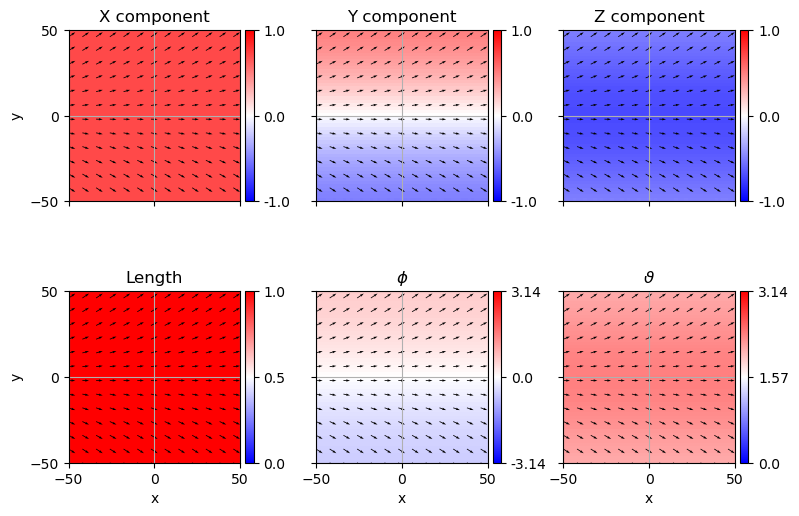

In [16]:
print("Drawing results...")
if show_midplane:
    fig, axs = plt.subplots(2, 3, figsize=(8.25, 2*8.25/3), sharex="col", sharey="row")

    patterns = ((x, y, z), (length, phi, theta))
    titles = (("X component", "Y component", "Z component"), ("Length", r"$\phi$", r"$\vartheta$"))
    mins = ((-1, -1, -1), (0, -np.pi, 0))
    maxs = ((1, 1, 1), (1, np.pi, np.pi))

    for i in range(2):
        for j in range(3):
            ax = axs[i, j]

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)

            f = ax.imshow(patterns[i][j][:, :, depth_index].T,
                          cmap="bwr",
                          extent=(-co_size[0]/2, co_size[0]/2,
                                  -co_size[1]/2, co_size[1]/2),
                          origin="lower",
                          vmin=mins[i][j],
                          vmax=maxs[i][j]
                      )

            cbar = fig.colorbar(f, cax=cax)
            cbar.set_ticks(np.linspace(mins[i][j], maxs[i][j], 3))
            cbar.set_ticklabels(np.round(np.linspace(mins[i][j], maxs[i][j], 3), 2))

            ax.set_xticks(np.linspace(-co_size[0]/2, co_size[0]/2, 3))
            ax.set_yticks(np.linspace(-co_size[1]/2, co_size[1]/2, 3))
            ax.grid()

            ax.quiver(smarter_reshape(coor[0], co_resolution)[::decimate, ::decimate, depth_index],
                      smarter_reshape(coor[1], co_resolution)[::decimate, ::decimate, depth_index],
                      field[0, ::decimate, ::decimate, depth_index],
                      field[1, ::decimate, ::decimate, depth_index])

            if i == 1:
                ax.set_xlabel("x")
            if j == 0:
                ax.set_ylabel("y")

            ax.set_title(titles[i][j])

    fig.tight_layout()
    fig.subplots_adjust(left=0.112,
                        bottom=0.05,
                        right=0.936,
                        top=1,
                        wspace=0.336,
                        hspace=0.0)
    plt.show()

## XZ plane

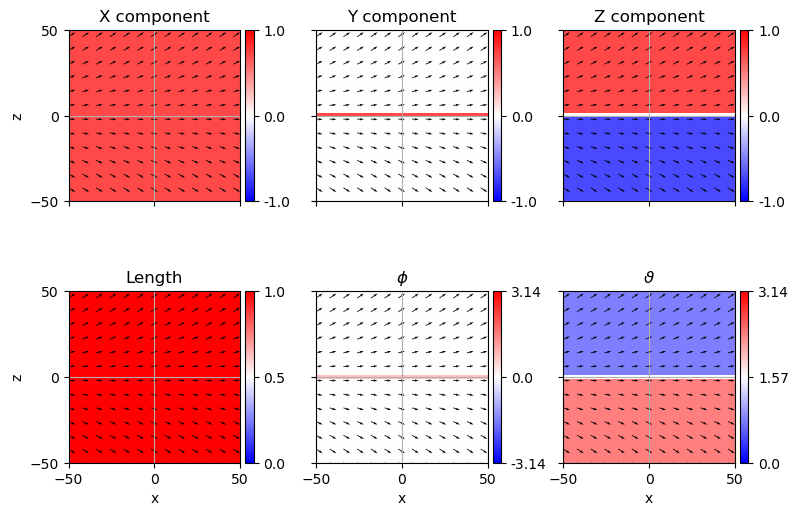

In [17]:
if show_midplane:
    fig, axs = plt.subplots(2, 3, figsize=( 8.25, 2*8.25/3), sharex="col", sharey="row")

    patterns = ((x, y, z), (length, phi, theta))
    titles = (("X component", "Y component", "Z component"), ("Length", r"$\phi$", r"$\vartheta$"))
    mins = ((-1, -1, -1), (0, -np.pi, 0))
    maxs = ((1, 1, 1), (1, np.pi, np.pi))

    for i in range(2):
        for j in range(3):
            ax = axs[i, j]

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            depth_index_xz = patterns[i][j].shape[1]//2
            f = ax.imshow(patterns[i][j][:, depth_index_xz, :].T,
                      cmap="bwr",
                      extent=(-co_size[0]/2, co_size[0]/2,
                              -co_size[2]/2, co_size[2]/2),
                      origin="lower",
                          vmin=mins[i][j],
                          vmax=maxs[i][j]
                      )

            cbar = fig.colorbar(f, cax=cax)
            cbar.set_ticks(np.linspace(mins[i][j], maxs[i][j], 3))
            cbar.set_ticklabels(np.round(np.linspace(mins[i][j], maxs[i][j], 3), 2))

            ax.set_xticks(np.linspace(-co_size[0]/2, co_size[0]/2, 3))
            ax.set_yticks(np.linspace(-co_size[2]/2, co_size[2]/2, 3))
            ax.grid()

            ax.quiver(smarter_reshape(coor[0], co_resolution)[::decimate, depth_index, ::decimate],
                      smarter_reshape(coor[2], co_resolution)[::decimate, depth_index, ::decimate],
                      field[0, ::decimate, depth_index, ::decimate],
                      field[2, ::decimate, depth_index, ::decimate])

            if i == 1:
                ax.set_xlabel("x")
            if j == 0:
                ax.set_ylabel("z")

            ax.set_title(titles[i][j])

    fig.tight_layout()
    fig.subplots_adjust(left=0.112,
                        bottom=0.05,
                        right=0.936,
                        top=1,
                        wspace=0.336,
                        hspace=0.0)
    plt.show()

## 3D

In [18]:
if show_3d:
    xx = smarter_reshape(coor[0], co_resolution)[::decimate, ::decimate, :].flatten()
    yy = smarter_reshape(coor[1], co_resolution)[::decimate, ::decimate, :].flatten()
    zz = smarter_reshape(coor[2], co_resolution)[::decimate, ::decimate, :].flatten()
    vx = field[0, ::decimate, ::decimate, :].flatten()
    vy = field[1, ::decimate, ::decimate, :].flatten()
    vz = field[2, ::decimate, ::decimate, :].flatten()
    phi_ = phi[::decimate, ::decimate, :].flatten()

    fig = go.Figure()

    fig = go.Figure(
        data=go.Cone(
            x=xx,
            y=yy,
            z=zz,
            u=vx,
            v=vy,
            w=vz,
            colorscale='Blues_r',
            sizemode="absolute",
            sizeref=3
        )
    )

    fig.update_layout(
        scene=dict(
            aspectmode="manual",
            aspectratio=dict(x=1, y=co_size[1]/co_size[0], z=co_size[2]/co_size[0])
        )
    )

    fig.show()